### III: Modelling & Tuning

In this notebook, once done with collecting the video and image data, transforming and processing them to coordinates, and doing EDA, we can now proceed with training our binary classification model (define whether good or bad posture). We will explore different type of models, evaluate them and then do hyperparameter tuning to achieve the best scores.

In [1]:
# problem statement - target audience: novice runners
# solution - EDA - bring the audience closer to my dataset - 1) what classes we're working with, 2) visual analysis (images / footage on good and bad form), 3) key differentiators of fgood and bad form
# impact - demo, recommendations, future work, scalability

# proportion of videos with good / bad form

In [5]:
!pip install scikit-learn==1.2.2

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import pickle

In [7]:
df = pd.read_csv('model_df.csv')
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,v33,good_posture,left_EyeSH,right_EyeSH,left_ESH,right_ESH,left_NSH,right_NSH,left_SHK,right_SHK
0,Bad,0.597514,0.330045,-0.046739,0.999786,0.595233,0.314657,-0.039935,0.999435,0.594381,...,0.995285,0,155.307020,172.507026,163.510284,178.116644,143.535033,161.939258,147.515758,146.922322
1,Bad,0.603381,0.325570,-0.049170,0.999806,0.601188,0.310604,-0.040726,0.999489,0.600242,...,0.994957,0,163.544608,169.504665,173.068362,179.864711,153.054688,159.226312,149.645177,148.347381
2,Bad,0.614878,0.315903,-0.031407,0.999825,0.613352,0.302009,-0.020730,0.999540,0.612598,...,0.995270,0,169.634487,163.841305,178.625314,173.993331,161.336623,153.260392,150.563715,147.488250
3,Bad,0.624886,0.308227,-0.035477,0.999842,0.623481,0.295145,-0.026631,0.999585,0.622720,...,0.995534,0,164.198492,163.581827,173.384369,173.911822,155.536213,153.985592,155.709640,150.075273
4,Bad,0.636889,0.295799,-0.043732,0.999856,0.634686,0.282637,-0.032385,0.999624,0.634024,...,0.995753,0,161.850092,166.930504,170.893832,176.967896,152.749715,157.711976,158.154844,151.350972


### Import Datasets

In [8]:
df.columns

Index(['class', 'x1', 'y1', 'z1', 'v1', 'x2', 'y2', 'z2', 'v2', 'x3',
       ...
       'v33', 'good_posture', 'left_EyeSH', 'right_EyeSH', 'left_ESH',
       'right_ESH', 'left_NSH', 'right_NSH', 'left_SHK', 'right_SHK'],
      dtype='object', length=142)

In [9]:
X = df[['left_EyeSH', 'right_EyeSH','left_ESH', 'right_ESH', 'left_NSH', 'right_NSH','left_SHK','right_SHK']]
y = df['good_posture']

# commentary / domain knowledge on why these angles are good - straight line?


Steps I took for this section:
1. Train Test Split
2. Create Pipeline for modelling
3. Create Function for Classification Reports
4. Run Different Models
5. Evaluate best model


#### 1. Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### 2. Function to define modelling pipeline

In [11]:
# Define pipeline with placeholders

pipeline = ImbPipeline([
    ('ss', StandardScaler()), 
    ('smotetomek', SMOTETomek(random_state=42)),
    ('clf', LogisticRegression()) 
])

#### 3. Function to define Classification Reports

In [12]:
# Generate Classifcation Reports

def report(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Classification Report for Train:\n", classification_report(y_train, y_train_pred))
    print("======================================================\n")
    print("Classification Report for Test:\n", classification_report(y_test, y_test_pred))

In [13]:
def run_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(10), verbose=1, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    return grid_search

In [14]:
# Define parameter grid

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter = 10000, solver='saga')],
    'clf__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'clf__penalty': ['l1', 'l2']
}

#### 4. Evaluating different classification models

#### 4.1 Baseline Model
We begin with creating a baseline model so that we have something to evaluate our final model against. The baseline model will be using Logistic Regression and all 33 coordinates collected by Mediapipe will be used as features. 

In [15]:
X = df.drop(columns = ['good_posture','class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
baseline_LR = LogisticRegression() 
baseline_LR.fit(X_train, y_train)
score = baseline_LR.score(X_test, y_test)

print(f"Baseline score using Logistic Regression is {score}")

Baseline score using Logistic Regression is 0.9430505774591796


/Users/anushaagarwal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 4.2 Logistic Regression

In [16]:
X = df[['left_EyeSH', 'right_EyeSH','left_ESH', 'right_ESH', 'left_NSH', 'right_NSH','left_SHK','right_SHK']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
%time
# Run grid search

grid_search_logreg = run_grid_search(pipeline, param_grid_logreg, X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 15 µs
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Logistic Regression: {'clf': LogisticRegression(C=0.5, max_iter=10000, penalty='l1', solver='saga'), 'clf__C': 0.5, 'clf__penalty': 'l1'}


In [18]:
# Save the model
LR = grid_search_logreg.best_estimator_

# Generate Classifcation Reports
report(LR)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3006
           1       0.91      0.95      0.93      2852

    accuracy                           0.93      5858
   macro avg       0.93      0.93      0.93      5858
weighted avg       0.93      0.93      0.93      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1288
           1       0.91      0.94      0.92      1223

    accuracy                           0.92      2511
   macro avg       0.92      0.92      0.92      2511
weighted avg       0.92      0.92      0.92      2511



In [19]:
def cmplot(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    cm_train = confusion_matrix(y_train, y_train_pred, labels=model.named_steps['clf'].classes_)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=model.named_steps['clf'].classes_)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.named_steps['clf'].classes_)
    disp_train.plot(ax=ax[0], cmap=plt.cm.Reds)
    ax[0].set_title('Confusion Matrix for Train Set')
    ax[0].set_xlabel('Predicted Good Pose')
    ax[0].set_ylabel('Actual Good Pose')
    ax[0].set_xticks(ticks=[0, 1])
    ax[0].set_yticks(ticks=[0, 1])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.named_steps['clf'].classes_)
    disp_test.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title('Confusion Matrix for Test Set')
    ax[1].set_xlabel('Predicted Good Pose')
    ax[1].set_ylabel('Actual Bad Pose')
    ax[1].set_xticks(ticks=[0, 1])
    ax[1].set_yticks(ticks=[0, 1])

    plt.tight_layout()
    plt.show()

In [20]:
# Generate ROC_AUC scores

def roc_auc(model):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_train_prob)

    y_test_prob = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_prob)


    print("ROC-AUC for Train:", roc_auc_train)
    print("ROC-AUC for Test:", roc_auc_test)

ROC-AUC for Train: 0.9593025263171646
ROC-AUC for Test: 0.9530961945729622


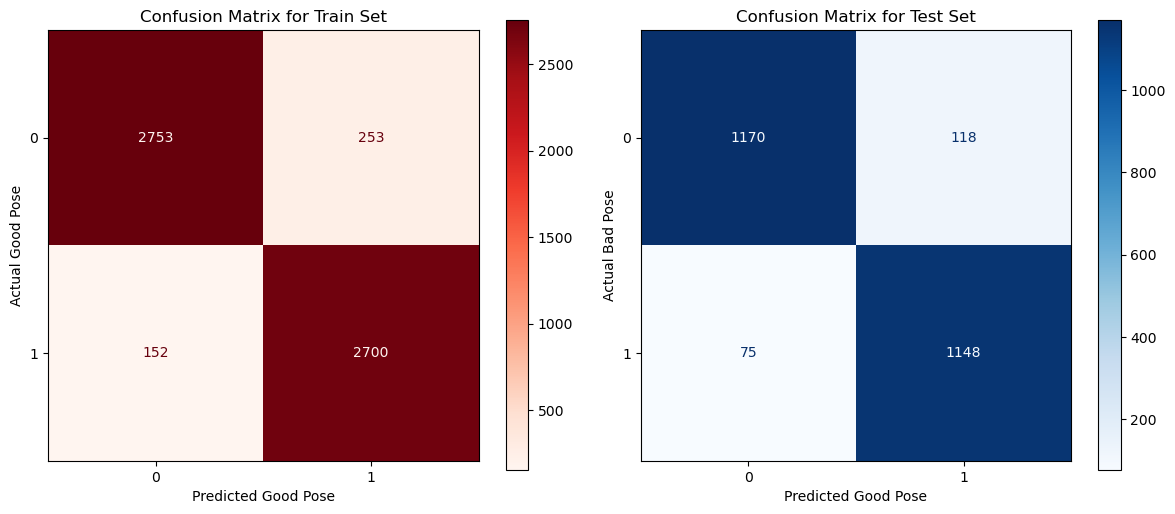

In [21]:
# Results for Logistic Regression
roc_auc(LR)
cmplot(LR)

#### 4.2 Random Forest

In [22]:
param_grid_rf = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True, False]
}

In [23]:
%time
# Run grid search

grid_search_rf = run_grid_search(pipeline, param_grid_rf, X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 11.9 µs
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters for Random Forest: {'clf': RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=200), 'clf__bootstrap': False, 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


In [24]:
# Save the model

RF = grid_search_rf.best_estimator_

In [25]:
roc_auc(RF)
report(RF)

ROC-AUC for Train: 0.9998187356003283
ROC-AUC for Test: 0.9991578975434605
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3006
           1       1.00      1.00      1.00      2852

    accuracy                           1.00      5858
   macro avg       1.00      1.00      1.00      5858
weighted avg       1.00      1.00      1.00      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1288
           1       0.98      0.99      0.99      1223

    accuracy                           0.99      2511
   macro avg       0.99      0.99      0.99      2511
weighted avg       0.99      0.99      0.99      2511



#### 4.3 K-Nearest Neighbour (KNN)

In [26]:
param_grid_knn = {
    'clf': [KNeighborsClassifier()],
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
    'clf__p': [1, 2]  # This is used only when metric is 'minkowski'. p=1 is manhattan, p=2 is euclidean.
}

In [27]:
%time
# Run grid search

grid_search_knn = run_grid_search(pipeline, param_grid_knn, X_train, y_train)
print("Best parameters for K-Nearest Neighbour:", grid_search_knn.best_params_)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs
Fitting 10 folds for each of 84 candidates, totalling 840 fits
Best parameters for K-Nearest Neighbour: {'clf': KNeighborsClassifier(metric='manhattan', n_neighbors=15, p=1,
                     weights='distance'), 'clf__metric': 'manhattan', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}


In [28]:
# Save the model

KNN = grid_search_knn.best_estimator_

ROC-AUC for Train: 0.9996575339270034
ROC-AUC for Test: 0.997121044372102
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3006
           1       1.00      1.00      1.00      2852

    accuracy                           1.00      5858
   macro avg       1.00      1.00      1.00      5858
weighted avg       1.00      1.00      1.00      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1288
           1       0.98      0.98      0.98      1223

    accuracy                           0.98      2511
   macro avg       0.98      0.98      0.98      2511
weighted avg       0.98      0.98      0.98      2511



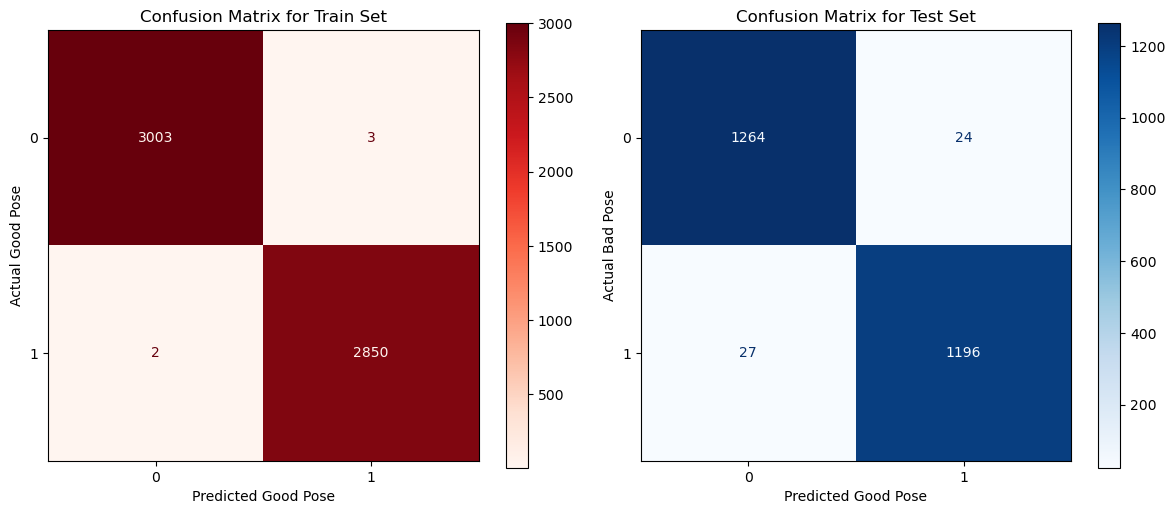

In [29]:
roc_auc(KNN)
report(KNN)
cmplot(KNN)

#### Saving and Loading the Trained Model using Pickle

In [30]:
# Select the final model
model = RF

In [31]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 


In [32]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9864595778574273
